In [1]:
import sys
from pathlib import Path

# Notebook: 03-Decision-Science/04-CEO-Request/data-olist-ceo-request/CEO_request.ipynb
# Bizim ana olist package: 03-Decision-Science/olist
project_root = Path().resolve().parents[2]  # -> .../03-Decision-Science
sys.path.insert(0, str(project_root))

project_root

PosixPath('/Users/gizemtotkanli/code/totkanligizem')

# CEO-Request Challenge

## 1. Sorun Tanımının Özeti

❓ **Olist kârını nasıl artırabilir?** ❓

### P&L Kuralları

#### Revenues  (Gelirler )
**Sales fees:** Olist, teslim edilen her order’ın ürün fiyatı üzerinden (freight hariç) **%10 pay** alır.  
**Subscription fees:** Olist, seller başına ayda **80 BRL** ücret alır.

#### Costs (Maliyetler)
Kötü review’lara (<= 3 stars) sahip orders için _tahmini_ **reputation costs**  

💡 Uzun vadede kötü customer experience iş açısından sonuçlara yol açar: düşük tekrar satın alma oranı, anında customer support maliyeti, refunds veya olumsuz word of mouth iletişimi. Her kötü review için parasal bir cost varsayımı yapıyoruz:

```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist'in total cumulated IT Costs değeri, platforma şimdiye kadar katılmış toplam seller sayısının karekökü ile, şimdiye kadar satılmış toplam birikimli item sayısının karekökü oranında ölçeklenir.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  

Olist'in data team’i bize bu scaling parameter’ları için şu değerleri verdi:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Yönetilen seller sayısı da, sales transaction sayısı da IT systems için maliyetlidir.
💡 Ancak karekök kullanımı scale-effects’i gösterir: IT-system’ler büyüdükçe daha verimli olma eğilimindedir.
💡 Alpha > Beta olması, Olist’in çok item satan az sayıda seller ile çalıştığında, bunun tersi senaryoya göre daha düşük IT Cost’a sahip olduğu anlamına gelir.

1000 sellers ve toplam 100 items satışıyla toplam IT cost 109,624 BRL olur

100 sellers ve toplam 1000 items satışıyla toplam IT cost 62,507 BRL olur

Son olarak, IT department size marketplace’in kuruluşundan bu yana birikmiş IT costs toplamının 500,000 BRL olduğunu da iletti.

Şimdi, bu IT cost formülünü biraz daha iyi anlamak için bir simulation çalıştıralım. Kod üzerinde zaman harcamanıza gerek yok, sadece ortaya çıkan chart’lara bakın.

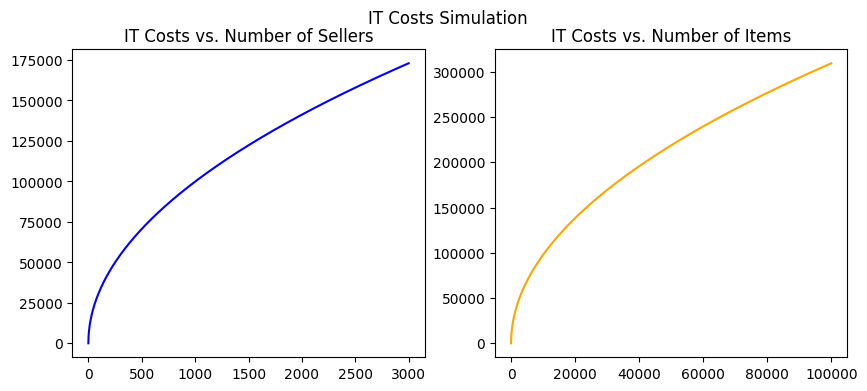

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alpha = 3157.27
beta = 978.23

x_sellers = np.arange(3_000)
y_it_costs_sellers = alpha * x_sellers ** 0.5

x_items = np.arange(100_000)
y_it_costs_items = beta * x_items ** 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_sellers, y_it_costs_sellers, label='IT costs per seller', color='blue')
plt.title('IT Costs vs. Number of Sellers')
plt.subplot(1, 2, 2)
plt.plot(x_items, y_it_costs_items, label='IT costs per item', color='orange')
plt.title('IT Costs vs. Number of Items')
plt.suptitle('IT Costs Simulation');

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from olist.seller import Seller

sellers = Seller().get_training_data()
sellers.shape, sellers.columns.tolist()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


((3095, 20),
 ['seller_city',
  'seller_id',
  'seller_state',
  'delay_to_carrier',
  'wait_time',
  'date_first_sale',
  'date_last_sale',
  'months_on_olist',
  'n_orders',
  'quantity',
  'quantity_per_order',
  'sales',
  'share_of_five_stars',
  'share_of_one_stars',
  'review_score',
  'sales_fee',
  'subscription_fee',
  'cost_of_reviews',
  'revenues',
  'profits'])

### Key Findings, so far

- `wait_time`, düşük review_score’ların arkasındaki en önemli faktördür.  
- `wait_time`, seller’ın `delay_to_carrier` süresi + `carrier_delivery_time` toplamından oluşur.  
- Carrier’ın delivery time’ı Olist’in doğrudan kontrolünde olmadığı için, bunu iyileştirmek hızlı kazanım sağlayacak bir öneri değildir.  
- Buna karşılık, daha iyi bir `seller` seçimi `delay_to_carrier` değerini olumlu şekilde etkileyebilir ve Olist üzerindeki kötü `review_scores` sayısını azaltabilir.  
- Kötü review’lardaki yorumlar, bazılarının seller’dan veya bizzat üründen kaynaklandığını göstermiştir.

💡 Aşağıdaki bölüm 2’deki guided seller analysis ile başlamanızı öneririz.

💪 Ancak bölüm 3 ile başka hipotezleri araştırmakta özgürsünüz.

## 2. Olist, performansları düşük satıcıları pazarından çıkarmalı mı? 🕵🏻
*(önerilen)*

Olist’in marketplace’inden en kötü seller’ları çıkarmanın etkisini analiz etmek için bir **what-if analysis** yapacağız.

👉 **Olist bu seller’ları en baştan hiç kabul etmemiş olsaydı ne olurdu?**  

*(Gerçekte, kimin iyi seller olduğunu önceden bilmek zordur, ancak bu yaklaşımla başlayıp daha sonra iterasyon yapacağız.)*


### 2.1 Veri Hazırlama

Her bir `seller_id` için, başlangıçtan itibaren kümülatif olarak hesaplayın:
- seller’ın getirdiği `revenues`
- seller’ın kötü review’larına bağlı `review_costs`
- ortaya çıkan `profits` (revenues - costs)

👉 İhtiyacınız olan DataFrame’i oluşturmak için adım adım bir strateji yazın.

⚠️ **Sıfırdan başlamayın, mevcut package’ınızı güncelleyin!** 😉

**Çözüm, notebook’a yeni kod yazmakta değil — `.py` dosyalarınızdaki kodu değiştirmektedir.**

`olist` package’ınız içindeki `Seller` class’ından başlayarak:

`get_training_data` method’unu düzenleyin; döndürdüğü DataFrame şu alanları içermeli:
- `revenues`: subscription + sales fees toplamı  
- `cost_of_reviews`: kötü review’lara bağlı toplam cost  
- `profits`: `revenues` - `cost_of_reviews`

`cost_of_reviews` için önce başka bir method’u değiştirmeniz gerekecek. Bununla ilgili olan method hangisi?

### 2.2 IT Maliyetleri Hariç Varsayım Analizi

👉 Gerçek analizi yapma zamanı. İlk olarak bunu IT costs **dahil etmeden** gerçekleştireceğiz.

Adımlarımız:  

1️⃣ Sellers verisini load edin ve profits değerine göre azalan şekilde sıralayın.

2️⃣ Cumulative değerleri hesaplayın:
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için cumulative items sold hesaplayın.

   Pandas ile cumulative sum nasıl hesaplanır, araştırın.

3️⃣ Sonuçlarınızı plot edin ve analiz edin. Pandas’ın `.plot()` method’unu kullanın.

4️⃣ Profits’e göre tutulması gereken optimum seller sayısını belirleyin. (İpucu: `np.argmax` araştırın). Bu kararın etkisi ne olurdu:
   - Net profit (IT costs dahil etmediğimiz için IT costs öncesi)?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

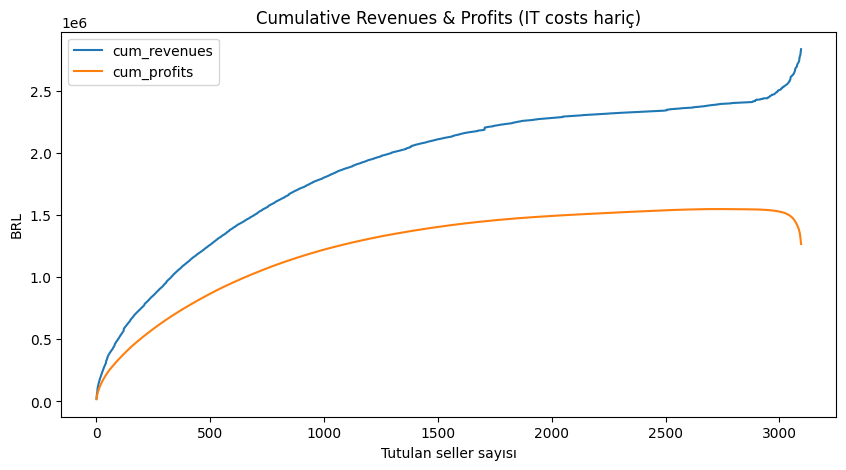

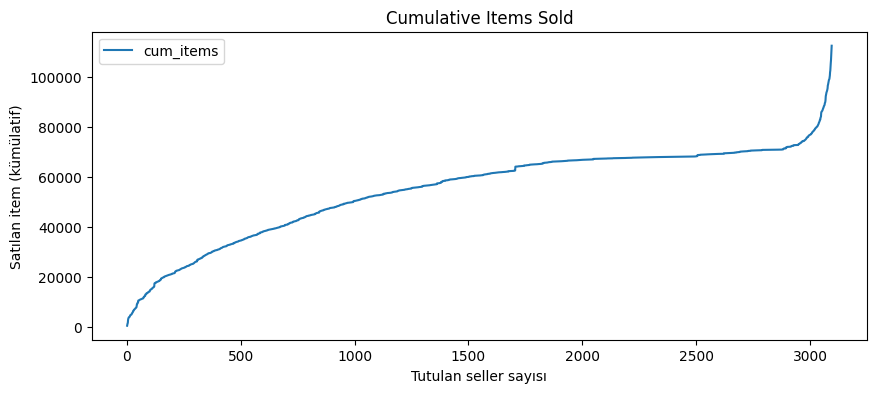

{'best_n_sellers_to_keep': 2724,
 'cum_profit_at_best_n': 1548329.0373333178,
 'cum_revenues_at_best_n': 2388895.7040000116,
 'cum_items_at_best_n': 70382.0,
 'total_sellers_initial': 3095,
 'sellers_to_remove': 371}

In [4]:
df = sellers.copy()

# Kötü seller’ları elemek için: profits büyükten küçüğe -> en iyi seller’ları "tutuyoruz"
df = df.sort_values('profits', ascending=False).reset_index(drop=True)

# Cumulative metrikler
df['cum_revenues'] = df['revenues'].cumsum()
df['cum_profits']  = df['profits'].cumsum()
df['cum_items']    = df['quantity'].cumsum()
df['cum_sellers']  = np.arange(1, len(df) + 1)

# Plot
ax = df.plot(x='cum_sellers', y=['cum_revenues', 'cum_profits'], figsize=(10,5))
ax.set_title("Cumulative Revenues & Profits (IT costs hariç)")
ax.set_xlabel("Tutulan seller sayısı")
ax.set_ylabel("BRL")
plt.show()

ax2 = df.plot(x='cum_sellers', y='cum_items', figsize=(10,4))
ax2.set_title("Cumulative Items Sold")
ax2.set_xlabel("Tutulan seller sayısı")
ax2.set_ylabel("Satılan item (kümülatif)")
plt.show()

# Optimum N (IT costs yokken): cum_profits maksimum olduğu nokta
best_idx = int(np.argmax(df['cum_profits'].values))
best_n = int(df.loc[best_idx, 'cum_sellers'])

impact = {
    "best_n_sellers_to_keep": best_n,
    "cum_profit_at_best_n": float(df.loc[best_idx, 'cum_profits']),
    "cum_revenues_at_best_n": float(df.loc[best_idx, 'cum_revenues']),
    "cum_items_at_best_n": float(df.loc[best_idx, 'cum_items']),
    "total_sellers_initial": int(len(df)),
    "sellers_to_remove": int(len(df) - best_n),
}

impact

### 2.3 IT maliyetleri ile varsayımsal analiz (İsteğe bağlı)

👉 Bu kez IT costs dahil edilerek gerçek analizi yapma zamanı.

Adımlarımız şunlar:  

1️⃣ İki parametreye göre IT costs hesaplayan bir function yazın: seller sayısı ve item sayısı. Temelde matematiksel formülü Python kullanarak yazmanız yeterli.

2️⃣ Sellers verisini load edin ve (IT costs öncesi) kârlarına göre azalan şekilde sıralayın.

3️⃣ Cumulative değerleri hesaplayın (önceki kodu yeniden kullanın):
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için toplam satılan item miktarının cumulative değerini hesaplayın.  

4️⃣ IT costs etkisini hesaplayın:
   - 1️⃣. adımda yazdığınız function’ı kullanarak her satır için cumulative IT cost ekleyin.
   - IT costs sonrası net profit’i hesaplayın.

5️⃣ Sonuçlarınızı plot edin ve analiz edin.

6️⃣ Bu kez IT costs sonrası kârları baz alarak tutulması gereken optimum seller sayısını belirleyin. Bu kararın etkisi ne olurdu:
   - IT costs sonrası net profit?
   - IT costs öncesi net profit?
   - IT costs?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

Analizinizde IT costs ne kadar önemliydi?


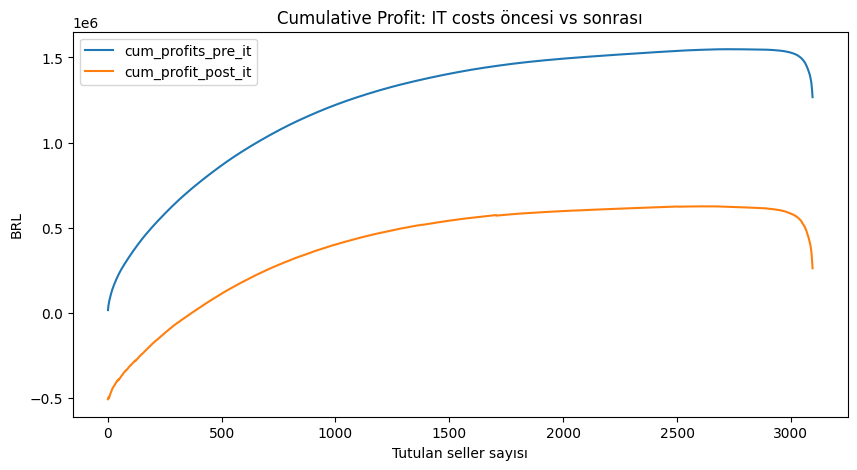

{'best_n_sellers_to_keep_post_it': 2621,
 'cum_profit_post_it_at_best_n': 626418.656535082,
 'cum_profit_pre_it_at_best_n': 1545632.907333318,
 'cum_it_cost_at_best_n': 919214.2507982359,
 'cum_revenues_at_best_n': 2365364.5740000103,
 'cum_items_at_best_n': 69331.0,
 'total_sellers_initial': 3095,
 'sellers_to_remove': 474}

In [5]:
alpha = 3157.27
beta = 978.23
fixed_it_costs = 500_000  # sabit (argmax'ı değiştirmez ama raporda nete yazarız)

def it_cost(n_sellers, n_items, include_fixed=True):
    c = alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)
    if include_fixed:
        c = c + fixed_it_costs
    return c

df2 = sellers.copy()
df2 = df2.sort_values('profits', ascending=False).reset_index(drop=True)

df2['cum_revenues'] = df2['revenues'].cumsum()
df2['cum_profits_pre_it']  = df2['profits'].cumsum()
df2['cum_items']    = df2['quantity'].cumsum()
df2['cum_sellers']  = np.arange(1, len(df2) + 1)

# IT cost ve IT sonrası net profit
df2['cum_it_cost'] = it_cost(df2['cum_sellers'], df2['cum_items'], include_fixed=True)
df2['cum_profit_post_it'] = df2['cum_profits_pre_it'] - df2['cum_it_cost']

ax = df2.plot(x='cum_sellers', y=['cum_profits_pre_it', 'cum_profit_post_it'], figsize=(10,5))
ax.set_title("Cumulative Profit: IT costs öncesi vs sonrası")
ax.set_xlabel("Tutulan seller sayısı")
ax.set_ylabel("BRL")
plt.show()

# Optimum N (IT costs sonrası)
best_idx2 = int(np.argmax(df2['cum_profit_post_it'].values))
best_n2 = int(df2.loc[best_idx2, 'cum_sellers'])

impact_it = {
    "best_n_sellers_to_keep_post_it": best_n2,
    "cum_profit_post_it_at_best_n": float(df2.loc[best_idx2, 'cum_profit_post_it']),
    "cum_profit_pre_it_at_best_n": float(df2.loc[best_idx2, 'cum_profits_pre_it']),
    "cum_it_cost_at_best_n": float(df2.loc[best_idx2, 'cum_it_cost']),
    "cum_revenues_at_best_n": float(df2.loc[best_idx2, 'cum_revenues']),
    "cum_items_at_best_n": float(df2.loc[best_idx2, 'cum_items']),
    "total_sellers_initial": int(len(df2)),
    "sellers_to_remove": int(len(df2) - best_n2),
}

impact_it

## 3. Diğer Yaklaşımları Araştırın 🕵️
*(isteğe bağlı)*

- Olist, en kötü performans gösteren ürünleri/kategorileri pazarından tamamen kaldırmalı mı?
- Olist, birkaç aylık balayı döneminden sonra, sadece sürekli olarak düşük performans gösteren satıcıları kaldırmalı mı?
- Olist, satıcılardan ürün listelerine belirli bilgileri eklemelerini zorunlu kılmalı mı?
- Olist, günün belirli saatlerinde müşterilerden satın alma onayı istemeli mi?
- Olist, gecikmeleri önlemek için belirli eyaletler arasındaki satıcı/müşteri çiftlerini kısıtlamalı mı?
- Olist, bazı maliyet varsayımları önerilerek yeni satıcılar kazanmalı mı?
- ...

## Sıra Sende!

🧺 Bu defteri düzenli tutun! 

🗣 📊 Bu `Communicate`  ünitesinin sonunda, en sevdiğiniz TA'ya görüşlerinizi sunacaksınız 💪

# 3. Diğer Yaklaşımlar (Opsiyonel)

Bu bölümde, kârlılığı artırmak için seller eleme yaklaşımına ek olarak farklı politika senaryolarını test ediyoruz.
Her senaryoda amaç: **revenue artışı / cost_of_reviews azalması / gecikmelerin düşmesi** gibi etkilere bakmak.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from olist.data import Olist
from olist.seller import Seller

olist = Olist()
data = olist.get_data()

sellers_df = Seller().get_training_data().copy()

def review_cost_from_score(score: float) -> float:
    """
    CEO challenge varsayımı:
    1★=100, 2★=50, 3★=40, 4-5★=0
    """
    if pd.isna(score):
        return 0.0
    score = int(score)
    return {1:100.0, 2:50.0, 3:40.0, 4:0.0, 5:0.0}.get(score, 0.0)

print("Loaded tables:", list(data.keys()))
print("sellers_df shape:", sellers_df.shape)

Loaded tables: ['customers', 'geolocation', 'order_items', 'order_payments', 'order_reviews', 'orders', 'product_category_name_translation', 'products', 'sellers']
sellers_df shape: (3095, 20)


## 3.1 En kötü ürün/kategorileri tamamen kaldırmalı mı?

### Hipotez
Bazı ürün kategorileri, getirdiği komisyona (sales_fee) kıyasla yüksek itibar maliyeti (review_cost) yaratıyor olabilir.
Bu durumda o kategorileri kaldırmak, toplam kârı artırabilir.

### Yaklaşım
- `order_items + products + category` ile ürün kategorisini buluruz.
- Review maliyetini order seviyesinde üretiriz.
- Aynı order’da birden fazla ürün/kategori olabilir → review_cost’u **order’daki item sayısına göre** item’lara paylaştırırız.
- Sonra kategori bazında:
  - `sales_fee = 0.10 * price`
  - `allocated_review_cost`
  - `category_profit = sales_fee - allocated_review_cost`

### Çıktı
- En kötü kategorileri sıralayıp,
- “En kötü K kategoriyi kapatsaydık” senaryosuyla toplam etkiyi hesaplarız.

In [7]:
# 1) order_items: order_id, product_id, price
order_items = data["order_items"][["order_id", "product_id", "price"]].copy()

# 2) products: product_id, product_category_name
products = data["products"][["product_id", "product_category_name"]].copy()

# 3) category translation (varsa)
cat_col = "product_category_name"
cat_translation = data.get("product_category_name_translation")
if cat_translation is not None:
    cat_translation = cat_translation.copy()
    # bazı datasetlerde kolon isimleri: product_category_name, product_category_name_english
    if "product_category_name_english" in cat_translation.columns:
        products = products.merge(cat_translation, on="product_category_name", how="left")
        cat_col = "product_category_name_english"

df = order_items.merge(products, on="product_id", how="left")

# kategori boşsa "unknown"
df[cat_col] = df[cat_col].fillna("unknown")

# sales_fee
df["sales_fee"] = 0.10 * df["price"]

# 4) review_score per order
reviews = data["order_reviews"][["order_id", "review_score"]].dropna().copy()
reviews["review_cost"] = reviews["review_score"].apply(review_cost_from_score)

df = df.merge(reviews[["order_id", "review_cost"]], on="order_id", how="left")
df["review_cost"] = df["review_cost"].fillna(0.0)

# 5) allocate review_cost to items within an order by item share (equal per item)
items_per_order = df.groupby("order_id")["product_id"].count().rename("n_items").reset_index()
df = df.merge(items_per_order, on="order_id", how="left")

df["allocated_review_cost"] = df["review_cost"] / df["n_items"].replace(0, np.nan)
df["allocated_review_cost"] = df["allocated_review_cost"].fillna(0.0)

# category aggregation
cat_pnl = df.groupby(cat_col, as_index=False).agg(
    sales_fee=("sales_fee", "sum"),
    allocated_review_cost=("allocated_review_cost", "sum"),
    n_items=("product_id", "count"),
    avg_price=("price", "mean")
)

cat_pnl["category_profit"] = cat_pnl["sales_fee"] - cat_pnl["allocated_review_cost"]
cat_pnl = cat_pnl.sort_values("category_profit").reset_index(drop=True)

cat_pnl.head(10)

,product_category_name_english,sales_fee,allocated_review_cost,n_items,avg_price,category_profit
0,bed_bath_table,105093.661,170269.880952,11270,93.250808,-65176.219952
1,telephony,32383.940,72544.166667,4550,71.173495,-40160.226667
2,furniture_decor,73628.247,112588.365801,8415,87.496431,-38960.118801
3,computers_accessories,91964.054,116341.666667,7894,116.498675,-24377.612667
4,electronics,16037.664,38918.333333,2768,57.939538,-22880.669333
5,housewares,63454.260,85393.452381,6989,90.791615,-21939.192381
6,sports_leisure,99365.651,110846.190476,8700,114.213392,-11480.539476
7,unknown,18579.172,29015.000000,1636,113.564621,-10435.828000
8,fashion_bags_accessories,15365.690,25161.666667,2050,74.954585,-9795.976667
9,baby,41211.747,48768.333333,3073,134.109167,-7556.586333


En iyi K (kategori kapatma): 46
Tahmini net kâr artışı (BRL): 305182.13


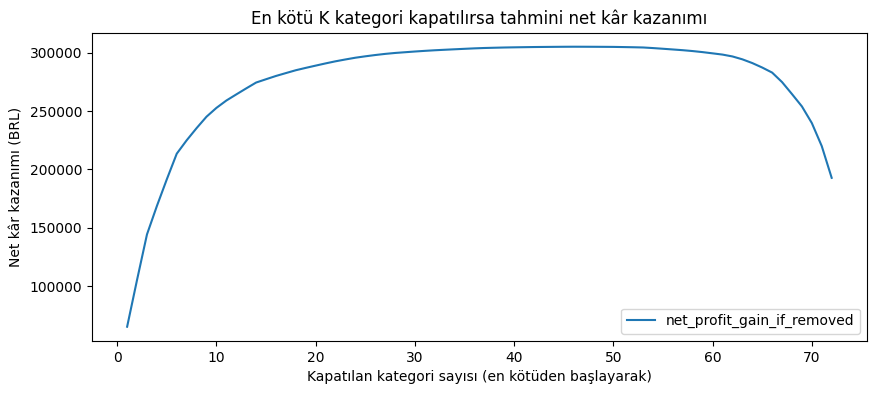

,product_category_name_english,category_profit,sales_fee,allocated_review_cost
0,bed_bath_table,-65176.219952,105093.661,170269.880952
1,telephony,-40160.226667,32383.940,72544.166667
2,furniture_decor,-38960.118801,73628.247,112588.365801
3,computers_accessories,-24377.612667,91964.054,116341.666667
4,electronics,-22880.669333,16037.664,38918.333333
5,housewares,-21939.192381,63454.260,85393.452381
6,sports_leisure,-11480.539476,99365.651,110846.190476
7,unknown,-10435.828000,18579.172,29015.000000
8,fashion_bags_accessories,-9795.976667,15365.690,25161.666667
9,baby,-7556.586333,41211.747,48768.333333


In [8]:
# Kategori kapatma senaryosu: en kötüden başlayarak çıkarmak
scenario = cat_pnl.copy()
scenario["cum_profit_removed"] = scenario["category_profit"].cumsum()
scenario["cum_sales_fee_removed"] = scenario["sales_fee"].cumsum()
scenario["cum_review_cost_removed"] = scenario["allocated_review_cost"].cumsum()
scenario["k_removed"] = np.arange(1, len(scenario) + 1)

# net etki (yaklaşık): kapatınca bu profit katkısı gider. 
# Eğer kategori_profit negatifse, kapatmak kârı artırır → "-(negatif)" pozitif kazanım.
scenario["net_profit_gain_if_removed"] = -scenario["cum_profit_removed"]

best_k = int(np.argmax(scenario["net_profit_gain_if_removed"].values)) + 1
best_gain = float(scenario.loc[best_k - 1, "net_profit_gain_if_removed"])

print("En iyi K (kategori kapatma):", best_k)
print("Tahmini net kâr artışı (BRL):", round(best_gain, 2))

ax = scenario.plot(x="k_removed", y="net_profit_gain_if_removed", figsize=(10,4))
ax.set_title("En kötü K kategori kapatılırsa tahmini net kâr kazanımı")
ax.set_xlabel("Kapatılan kategori sayısı (en kötüden başlayarak)")
ax.set_ylabel("Net kâr kazanımı (BRL)")
plt.show()

scenario.loc[:best_k-1, [cat_col, "category_profit", "sales_fee", "allocated_review_cost"]].head(20)

## 3.2 “Balayı” dönemi sonrası sürekli düşük performanslı seller’ı kaldırmalı mı?

### Hipotez
Bazı satıcılar ilk aylarda kabul edilebilir performans gösterip daha sonra sürekli kötüleşebilir.
İlk X ayı “honeymoon” sayıp, sonraki aylarda **sürekli kötü** olan seller’ları çıkarmak daha adil ve daha güvenli olabilir.

### Yaklaşım
- Order'ları ay bazına indirgeriz.
- Seller-ay bazında:
  - `sales_fee` (0.10 * price)
  - `allocated_review_cost` (order review_cost'u order içindeki seller’lara paylaştırarak)
  - `monthly_profit = sales_fee - allocated_review_cost`
- Honeymoon sonrası (örn. 3 ay) için:
  - En az `M` ay üst üste `monthly_profit < 0` olan seller’ı “kronik kötü” diye işaretleriz.

### Çıktı
- Kaç seller gider?
- Toplam kâra etkisi yaklaşık ne olur?

In [9]:
orders = data["orders"][["order_id", "order_purchase_timestamp"]].dropna().copy()
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["year_month"] = orders["order_purchase_timestamp"].dt.to_period("M").astype(str)

# seller per order: unique sellers in an order
order_sellers = data["order_items"][["order_id", "seller_id"]].drop_duplicates()

# delivered items for sales_fee
delivered = data["orders"].query("order_status=='delivered'")[["order_id"]]
items = data["order_items"][["order_id", "seller_id", "price"]].merge(delivered, on="order_id", how="inner")
items["sales_fee"] = 0.10 * items["price"]

seller_month_salesfee = items.merge(orders[["order_id","year_month"]], on="order_id", how="left") \
    .groupby(["seller_id","year_month"], as_index=False)["sales_fee"].sum()

# review_cost per order
reviews = data["order_reviews"][["order_id", "review_score"]].dropna().copy()
reviews["review_cost"] = reviews["review_score"].apply(review_cost_from_score)

# allocate review cost across sellers in the same order equally
osr = order_sellers.merge(reviews[["order_id","review_cost"]], on="order_id", how="inner")
n_sellers = osr.groupby("order_id")["seller_id"].nunique().rename("n_sellers").reset_index()
osr = osr.merge(n_sellers, on="order_id", how="left")
osr["allocated_review_cost"] = osr["review_cost"] / osr["n_sellers"].replace(0, np.nan)
osr["allocated_review_cost"] = osr["allocated_review_cost"].fillna(0.0)

seller_month_reviewcost = osr.merge(orders[["order_id","year_month"]], on="order_id", how="left") \
    .groupby(["seller_id","year_month"], as_index=False)["allocated_review_cost"].sum() \
    .rename(columns={"allocated_review_cost":"review_cost"})

seller_month = seller_month_salesfee.merge(seller_month_reviewcost, on=["seller_id","year_month"], how="outer").fillna(0.0)
seller_month["monthly_profit"] = seller_month["sales_fee"] - seller_month["review_cost"]

seller_month.head()

,seller_id,year_month,sales_fee,review_cost,monthly_profit
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09,89.50,0.0,89.50
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10,179.00,100.0,79.00
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02,109.89,50.0,59.89
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03,167.67,340.0,-172.33
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04,170.82,330.0,-159.18


In [10]:
# Parametreler
HONEYYMOON_MONTHS = 3
CONSEC_BAD_MONTHS = 3  # üst üste kaç ay negatif profit olursa "kronik kötü"

# seller'ların aktif başladığı ay (ilk ay)
seller_first_month = (
    seller_month[seller_month["sales_fee"] > 0]
    .groupby("seller_id")["year_month"]
    .min()
    .rename("first_month")
    .reset_index()
)

tmp = seller_month.merge(seller_first_month, on="seller_id", how="left")

# year_month ve first_month -> datetime'e çevir (ay başı)
tmp["ym_dt"] = pd.to_datetime(tmp["year_month"] + "-01", errors="coerce")
tmp["first_dt"] = pd.to_datetime(tmp["first_month"] + "-01", errors="coerce")

# ay indexi (tam sayısal): (y*12+m) farkı
tmp["month_idx"] = (
    (tmp["ym_dt"].dt.year * 12 + tmp["ym_dt"].dt.month)
    - (tmp["first_dt"].dt.year * 12 + tmp["first_dt"].dt.month)
).astype("Int64")  # nullable int

# honeymoon sonrası aylar
post = tmp[tmp["month_idx"] >= HONEYYMOON_MONTHS].copy()
post = post.sort_values(["seller_id", "ym_dt"])

# üst üste negatif ay sayısını bulalım
post["is_bad"] = post["monthly_profit"] < 0

def max_consecutive_true(series_bool):
    max_run = run = 0
    for v in series_bool:
        if bool(v):
            run += 1
            max_run = max(max_run, run)
        else:
            run = 0
    return max_run

seller_bad_run = (
    post.groupby("seller_id")["is_bad"]
    .apply(max_consecutive_true)
    .rename("max_bad_streak")
    .reset_index()
)

chronic_bad = seller_bad_run.loc[seller_bad_run["max_bad_streak"] >= CONSEC_BAD_MONTHS, "seller_id"]

print("Kronik kötü seller sayısı:", chronic_bad.nunique())

# Etki (yaklaşık): bu seller'ların toplam monthly_profit katkısını çıkarırsak ne olur?
total_profit_all = seller_month["monthly_profit"].sum()
profit_chronic = seller_month.loc[seller_month["seller_id"].isin(chronic_bad), "monthly_profit"].sum()

print("Toplam profit (seller-month yaklaşımı):", round(total_profit_all, 2))
print("Kronik kötülerin toplam katkısı:", round(profit_chronic, 2))
print("Bunları kaldırınca beklenen artış (yaklaşık):", round(-profit_chronic, 2))

Kronik kötü seller sayısı: 341
Toplam profit (seller-month yaklaşımı): -245740.19
Kronik kötülerin toplam katkısı: -455605.63
Bunları kaldırınca beklenen artış (yaklaşık): 455605.63


## 3.3 Satıcılardan ürün listelerine belirli bilgileri zorunlu kılmak işe yarar mı?

### Hipotez
Ürün bilgisi eksik (ölçü/ağırlık/foto vb.) ürünlerde müşteri memnuniyeti daha düşük olabilir.
Bu da kötü review oranını artırıp `cost_of_reviews`’u yükseltir.

### Proxy (mevcut Olist kolonları)
- `product_photos_qty`
- `product_weight_g`, `product_length_cm`, `product_height_cm`, `product_width_cm`
- `product_description_lenght` / `product_name_lenght`

### Test
“Eksik bilgi flag” oluştur:
- örn. photos <= 1 OR weight boş OR dimensions boş
Sonra:
- bu flag = 1 olanlarda `bad_review_rate` daha mı yüksek?

In [11]:
# ürün özellikleri
prod_cols = [
    "product_id",
    "product_photos_qty",
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm",
    "product_name_lenght",
    "product_description_lenght",
]
products_full = data["products"][prod_cols].copy()

# item-level dataset: order_id, product_id
oi = data["order_items"][["order_id","product_id"]].copy()

# review per order
rev = data["order_reviews"][["order_id","review_score"]].dropna().copy()
rev["bad_review"] = (rev["review_score"] <= 3).astype(int)

item_rev = oi.merge(products_full, on="product_id", how="left") \
             .merge(rev[["order_id","bad_review","review_score"]], on="order_id", how="left")

# missing flags
item_rev["missing_dims"] = item_rev[["product_length_cm","product_height_cm","product_width_cm"]].isna().any(axis=1).astype(int)
item_rev["missing_weight"] = item_rev["product_weight_g"].isna().astype(int)
item_rev["low_photos"] = (item_rev["product_photos_qty"].fillna(0) <= 1).astype(int)
item_rev["missing_desc"] = item_rev["product_description_lenght"].isna().astype(int)

item_rev["missing_info_flag"] = (
    (item_rev["missing_dims"] == 1) |
    (item_rev["missing_weight"] == 1) |
    (item_rev["low_photos"] == 1) |
    (item_rev["missing_desc"] == 1)
).astype(int)

# bad review rate compare
summary = item_rev.groupby("missing_info_flag").agg(
    n_items=("product_id","count"),
    bad_review_rate=("bad_review","mean"),
    avg_review=("review_score","mean")
)

summary

,n_items,bad_review_rate,avg_review
missing_info_flag,,,
0,55267,0.233868,4.072552
1,58047,0.255622,3.994282


## 3.4 Günün belirli saatlerinde satın alma onayı istemeli mi?

### Hipotez
Bazı saat aralıklarında yapılan alışverişlerde (gece vs.) kötü review veya iptal oranı daha yüksek olabilir.
Bu saatlere “ek onay” koymak (friction) sorunlu siparişleri azaltabilir.

### Test
- `order_purchase_timestamp` -> saat çıkar
- Saat bazında:
  - `bad_review_rate`
  - (varsa) iptal oranı

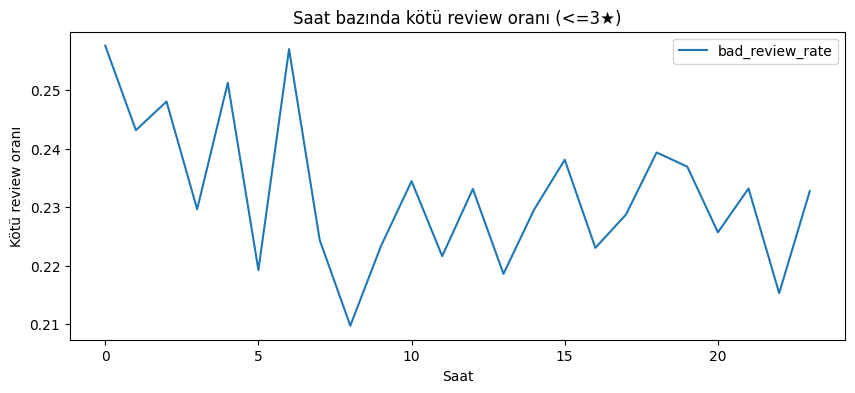

,hour,n_orders,bad_review_rate
0,0,2366,0.257550
6,6,498,0.256972
4,4,205,0.251208
2,2,504,0.248016
1,1,1157,0.243127
18,18,5724,0.239327
15,15,6404,0.238080
19,19,5932,0.236904


In [12]:
orders = data["orders"][["order_id","order_purchase_timestamp","order_status"]].dropna().copy()
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["hour"] = orders["order_purchase_timestamp"].dt.hour

rev = data["order_reviews"][["order_id","review_score"]].dropna().copy()
rev["bad_review"] = (rev["review_score"] <= 3).astype(int)

df_hour = orders.merge(rev[["order_id","bad_review"]], on="order_id", how="inner")

hour_stats = df_hour.groupby("hour").agg(
    n_orders=("order_id","nunique"),
    bad_review_rate=("bad_review","mean")
).reset_index()

hour_stats.plot(x="hour", y="bad_review_rate", figsize=(10,4))
plt.title("Saat bazında kötü review oranı (<=3★)")
plt.xlabel("Saat")
plt.ylabel("Kötü review oranı")
plt.show()

hour_stats.sort_values("bad_review_rate", ascending=False).head(8)

## 3.5 Belirli seller_state → customer_state çiftlerini kısıtlamak işe yarar mı?

### Hipotez
Bazı eyalet çiftlerinde teslimat süreleri (wait_time) daha uzun olduğu için kötü review artıyor olabilir.
Bu çiftleri kısıtlamak, kötü review maliyetini düşürebilir.

### Test
- orders + customers + sellers ile state pair üret
- pair bazında:
  - avg_wait_time
  - bad_review_rate

In [13]:
orders = data["orders"].copy()
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders_del = orders.query("order_status=='delivered'").copy()

customers = data["customers"][["customer_id","customer_state"]].drop_duplicates()
sellers = data["sellers"][["seller_id","seller_state"]].drop_duplicates()

# order_items ile seller bağla (order-seller unique)
order_sellers = data["order_items"][["order_id","seller_id"]].drop_duplicates()

# wait_time: delivered_customer - purchase
orders_del["order_delivered_customer_date"] = pd.to_datetime(orders_del["order_delivered_customer_date"])
orders_del["wait_time"] = (orders_del["order_delivered_customer_date"] - orders_del["order_purchase_timestamp"]) / np.timedelta64(1, "D")

rev = data["order_reviews"][["order_id","review_score"]].dropna().copy()
rev["bad_review"] = (rev["review_score"] <= 3).astype(int)

pairs = (
    order_sellers
    .merge(sellers, on="seller_id", how="left")
    .merge(orders_del[["order_id","customer_id","wait_time"]], on="order_id", how="inner")
    .merge(customers, on="customer_id", how="left")
    .merge(rev[["order_id","bad_review"]], on="order_id", how="left")
)

pairs["bad_review"] = pairs["bad_review"].fillna(0)

pair_stats = pairs.groupby(["seller_state","customer_state"], as_index=False).agg(
    n_orders=("order_id","nunique"),
    avg_wait_time=("wait_time","mean"),
    bad_review_rate=("bad_review","mean")
)

# çok az örnekli pair'leri ele (gürültü)
pair_stats_f = pair_stats[pair_stats["n_orders"] >= 50].copy()

# en kötü 10 pair
pair_stats_f.sort_values(["bad_review_rate","avg_wait_time"], ascending=False).head(10)

,seller_state,customer_state,n_orders,avg_wait_time,bad_review_rate
258,PR,CE,64,25.011858,0.415385
394,SP,MA,493,21.998548,0.340000
356,SC,BA,79,20.702155,0.337500
386,SP,AL,256,24.980932,0.333333
285,RJ,CE,54,24.916870,0.333333
409,SP,SE,208,21.256960,0.309524
68,DF,RJ,96,13.983247,0.302083
156,MG,MT,53,20.990235,0.301887
398,SP,PA,683,23.313996,0.295389
389,SP,BA,2313,19.764210,0.292641


## 3.6 Yeni seller kazanmalı mı? (IT cost ve kalite riskiyle)

### Hipotez
Yeni seller:
- subscription gelirini artırır
- fakat kötü seller gelirse review cost’u artırır
- ayrıca IT cost (sqrt ölçekli) artar

### Yaklaşım
Basit bir simülasyon:
- “Yeni seller paketinin” ortalama sales_fee, review_cost katkısı varsayılır
- IT cost formülü ile marjinal etki eklenir
Bu sayede “kaç seller eklemek mantıklı” kaba bir çerçeve verir.

Not: Bu bölümde amaç kesin rakam değil; karar mantığını göstermek.

In [14]:
alpha = 3157.27
beta = 978.23
fixed_it_costs = 500_000

def it_cost(n_sellers, n_items, include_fixed=True):
    c = alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)
    if include_fixed:
        c = c + fixed_it_costs
    return c

# mevcut durum (yaklaşık)
base_n_sellers = sellers_df["seller_id"].nunique()
base_n_items = int(sellers_df["quantity"].sum())

base_it = it_cost(base_n_sellers, base_n_items, include_fixed=True)

print("Base sellers:", base_n_sellers)
print("Base items:", base_n_items)
print("Base IT cost:", round(base_it, 2))

# Yeni seller senaryosu için varsayımlar (oynanabilir)
avg_sales_fee_per_new_seller = sellers_df["sales_fee"].mean()
avg_review_cost_per_new_seller = sellers_df["cost_of_reviews"].mean()
avg_items_per_new_seller = sellers_df["quantity"].mean()

def simulate_add_sellers(k_new):
    new_sellers = base_n_sellers + k_new
    new_items = base_n_items + int(k_new * avg_items_per_new_seller)

    # revenue/cost katkısı (basit)
    delta_profit_before_it = k_new * (avg_sales_fee_per_new_seller - avg_review_cost_per_new_seller)
    delta_it = it_cost(new_sellers, new_items, include_fixed=True) - base_it

    # net
    net_delta = delta_profit_before_it - delta_it
    return {
        "k_new": k_new,
        "delta_profit_before_it": float(delta_profit_before_it),
        "delta_it_cost": float(delta_it),
        "net_delta_profit": float(net_delta),
        "new_sellers": int(new_sellers),
        "new_items": int(new_items),
    }

results = pd.DataFrame([simulate_add_sellers(k) for k in [0, 50, 100, 200, 300, 500]])
results

Base sellers: 3095
Base items: 112650
Base IT cost: 1003974.51


,k_new,delta_profit_before_it,delta_it_cost,net_delta_profit,new_sellers,new_items
0,0,-0.000000,0.000000,-0.000000,3095,112650
1,50,-3969.954588,4053.307839,-8023.262427,3145,114469
2,100,-7939.909176,8075.965579,-16015.874755,3195,116289
3,200,-15879.818352,16027.933480,-31907.751832,3295,119929
4,300,-23819.727528,23860.116480,-47679.844008,3395,123569
5,500,-39699.545880,39184.423841,-78883.969722,3595,130848


In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import pandas as pd

from olist.seller import Seller

sellers = Seller().get_training_data().copy()

# Gerekli kolonlar yoksa üret (özellikle profits)
if "cost_of_reviews" not in sellers.columns:
    raise KeyError("cost_of_reviews kolonu yok. Seller.get_training_data() içinde cost_of_reviews üretilmeli.")

if "revenues" not in sellers.columns:
    # Bazı implementasyonlarda revenues yoksa şu ikisini kullanırız:
    if "sales_fee" in sellers.columns and "subscription_fee" in sellers.columns:
        sellers["revenues"] = sellers["sales_fee"] + sellers["subscription_fee"]
    else:
        raise KeyError("revenues yok ve sales_fee/subscription_fee da yok. Seller.get_training_data() kontrol edilmeli.")

if "profits" not in sellers.columns:
    sellers["profits"] = sellers["revenues"] - sellers["cost_of_reviews"]

# hızlı kontrol
print(sellers.shape)
print([c for c in ["revenues","cost_of_reviews","profits","quantity"] if c in sellers.columns])
sellers.head(3)

(3095, 20)
['revenues', 'cost_of_reviews', 'profits', 'quantity']


,seller_city,seller_id,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,sales_fee,subscription_fee,cost_of_reviews,revenues,profits
0,campinas,3442f8959a84dea7ee197c632cb2df15,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.00,21.870,320.0,120.0,341.870,221.870
1,mogi guacu,d1b65fc7debc3361ea86b5f14c68d2e2,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.725000,0.050000,4.55,1141.317,1120.0,240.0,2261.317,2021.317
2,rio de janeiro,ce3ad9de960102d0677a81f5d0bb7b2d,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,1.000000,0.000000,5.00,15.800,80.0,0.0,95.800,95.800


In [17]:
alpha = 3157.27
beta = 978.23
fixed_it_cost = 500_000  # sabit

def it_cost(n_sellers, n_items, include_fixed=True):
    c = alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)
    if include_fixed:
        c = c + fixed_it_cost
    return c

In [18]:
def simulate_policy(
    base_df: pd.DataFrame,
    remove_worst_pct: float = 0.10,
    it_cost_multiplier: float = 1.0,
    review_cost_multiplier: float = 1.0,
    include_fixed_it: bool = True,
    profit_col: str = "profits",
):
    df = base_df.copy()

    # Kolon emniyeti
    if profit_col not in df.columns:
        # fallback: profits yoksa üretmeye çalış
        if "revenues" in df.columns and "cost_of_reviews" in df.columns:
            df["profits"] = df["revenues"] - df["cost_of_reviews"]
            profit_col = "profits"
        else:
            raise KeyError(f"'{profit_col}' yok; ayrıca revenues/cost_of_reviews da yok. DataFrame kolonlarını kontrol et.")

    if "quantity" not in df.columns:
        raise KeyError("quantity kolonu yok (n_items için gerekli).")

    if "revenues" not in df.columns:
        raise KeyError("revenues kolonu yok (gelir için gerekli).")

    if "cost_of_reviews" not in df.columns:
        raise KeyError("cost_of_reviews kolonu yok (review cost için gerekli).")

    # 1) En kötü %X seller'ı çıkar -> geriye en iyi (1-remove_worst_pct) kalsın
    keep_n = int(round(len(df) * (1 - remove_worst_pct)))
    keep_n = max(1, min(keep_n, len(df)))  # güvenlik

    df = df.sort_values(profit_col, ascending=False).iloc[:keep_n].copy()

    # 2) Maliyet varsayımları
    adj_review_cost = df["cost_of_reviews"].sum() * review_cost_multiplier

    n_sellers = len(df)
    n_items = df["quantity"].sum()

    adj_it_cost = it_cost(n_sellers=n_sellers, n_items=n_items, include_fixed=include_fixed_it) * it_cost_multiplier

    # 3) Toplamlar
    total_revenue = df["revenues"].sum()
    net_profit = total_revenue - adj_review_cost - adj_it_cost

    return {
        "kept_sellers": int(n_sellers),
        "remove_worst_pct": float(remove_worst_pct),
        "total_revenue": float(total_revenue),
        "review_costs": float(adj_review_cost),
        "it_costs": float(adj_it_cost),
        "net_profit": float(net_profit),
        "n_items": float(n_items),
    }

In [19]:
scenarios = [
    {"remove_worst_pct": 0.10, "it_cost_multiplier": 1.0, "review_cost_multiplier": 1.0},
    {"remove_worst_pct": 0.20, "it_cost_multiplier": 1.0, "review_cost_multiplier": 1.0},
    {"remove_worst_pct": 0.10, "it_cost_multiplier": 0.90, "review_cost_multiplier": 1.0},
    {"remove_worst_pct": 0.10, "it_cost_multiplier": 1.0, "review_cost_multiplier": 0.90},
    {"remove_worst_pct": 0.20, "it_cost_multiplier": 0.90, "review_cost_multiplier": 0.90},
]

results = [simulate_policy(sellers, **s) for s in scenarios]
res_df = pd.DataFrame(results).sort_values("net_profit", ascending=False)

res_df

,kept_sellers,remove_worst_pct,total_revenue,review_costs,it_costs,net_profit,n_items
4,2476,0.2,2338469.293,721557.000000,821360.157806,795552.135194,68228.0
2,2786,0.1,2399258.430,851426.666667,834185.451322,713646.312011,70764.0
3,2786,0.1,2399258.430,766284.000000,926872.723692,706101.706308,70764.0
1,2476,0.2,2338469.293,801730.000000,912622.397562,624116.895438,68228.0
0,2786,0.1,2399258.430,851426.666667,926872.723692,620959.039642,70764.0


### Basit politika simülasyonu (senaryo oynatma)

Amaç: “En kötü %X satıcıyı çıkarmak” + “IT maliyet ölçeği” + “kötü review maliyeti varsayımları” gibi kaldıraçların net kâra etkisini hızlıca görmek.

Simülasyon varsayımları:
- Satıcı eleme: profits (revenues - cost_of_reviews) metriğine göre en kötü %X satıcı elenir.
- Review cost: cost_of_reviews toplamı, review_cost_multiplier ile ölçeklenir.
- IT cost: α*sqrt(n_sellers)+β*sqrt(n_items) (+ sabit 500k opsiyonel) ve it_cost_multiplier ile ölçeklenir.

Çıktılar:
- kept_sellers, n_items
- total_revenue, review_costs, it_costs
- net_profit

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from olist.seller import Seller

# 1) Temel tablo
sellers = Seller().get_training_data().copy()

# 2) Gerekli kolonları garanti altına al
required_cols = ["revenues", "cost_of_reviews", "profits", "quantity"]
missing = [c for c in required_cols if c not in sellers.columns]
if missing:
    print("Eksik kolonlar bulundu, tamamlıyorum:", missing)

# profits yoksa revenues - cost_of_reviews olarak üret
if "profits" not in sellers.columns:
    if "revenues" in sellers.columns and "cost_of_reviews" in sellers.columns:
        sellers["profits"] = sellers["revenues"] - sellers["cost_of_reviews"]
    else:
        raise ValueError("profits üretmek için revenues ve cost_of_reviews gerekir.")

# quantity yoksa (items sold) order_items sayısı yerine güvenli fallback
if "quantity" not in sellers.columns:
    # Eğer quantity yoksa ama n_orders/quantity_per_order vb. varsa üretmeye çalış
    if "n_orders" in sellers.columns and "quantity_per_order" in sellers.columns:
        sellers["quantity"] = sellers["n_orders"] * sellers["quantity_per_order"]
    else:
        raise ValueError("quantity yok; it_cost hesabı için quantity (satılan item) gerekiyor.")

# Sayısal tip güvenliği
for c in ["revenues", "cost_of_reviews", "profits", "quantity"]:
    sellers[c] = pd.to_numeric(sellers[c], errors="coerce").fillna(0)

sellers.shape, sellers.columns.tolist()

((3095, 20),
 ['seller_city',
  'seller_id',
  'seller_state',
  'delay_to_carrier',
  'wait_time',
  'date_first_sale',
  'date_last_sale',
  'months_on_olist',
  'n_orders',
  'quantity',
  'quantity_per_order',
  'sales',
  'share_of_five_stars',
  'share_of_one_stars',
  'review_score',
  'sales_fee',
  'subscription_fee',
  'cost_of_reviews',
  'revenues',
  'profits'])

In [21]:
# Parametreler (notebook'taki değerlerle uyumlu)
alpha = 3157.27
beta = 978.23
fixed_it_costs = 500_000  # sabit IT (notebook metninde var)

def it_cost(n_sellers, n_items, include_fixed=True):
    """
    IT_costs = alpha * sqrt(n_sellers) + beta * sqrt(n_items) + fixed(optional)
    """
    c = alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)
    if include_fixed:
        c = c + fixed_it_costs
    return c

def simulate_policy(
    base_df: pd.DataFrame,
    remove_worst_pct=0.10,
    it_cost_multiplier=1.0,
    review_cost_multiplier=1.0,
):
    """
    Basit politika simülasyonu:
      - En kötü X%'i çıkarmayı, 'profits' üzerinden sıralayıp en iyileri tutarak simüle ediyor.
      - Review maliyetini ve IT maliyetini çarpanla değiştirip net etkiyi ölçüyor.
    """
    df = base_df.copy()

    # güvenlik
    if "profits" not in df.columns:
        raise KeyError("DataFrame'de 'profits' yok.")
    if "quantity" not in df.columns:
        raise KeyError("DataFrame'de 'quantity' yok.")
    if "cost_of_reviews" not in df.columns:
        raise KeyError("DataFrame'de 'cost_of_reviews' yok.")
    if "revenues" not in df.columns:
        raise KeyError("DataFrame'de 'revenues' yok.")

    # keep oranı
    keep_ratio = 1 - remove_worst_pct
    keep_ratio = min(max(keep_ratio, 0.0), 1.0)

    cutoff = int(np.floor(len(df) * keep_ratio))
    cutoff = max(cutoff, 1)  # en az 1 seller kalsın

    # En iyi seller'ları tut
    df = df.sort_values("profits", ascending=False).iloc[:cutoff]

    # Toplamlar
    total_revenue = float(df["revenues"].sum())
    review_cost = float(df["cost_of_reviews"].sum()) * float(review_cost_multiplier)

    n_sellers = int(len(df))
    n_items = float(df["quantity"].sum())

    it_c = float(it_cost(n_sellers=n_sellers, n_items=n_items, include_fixed=True)) * float(it_cost_multiplier)

    # net profit = revenues - review_cost - it_cost
    net_profit = total_revenue - review_cost - it_c

    return {
        "remove_worst_pct": float(remove_worst_pct),
        "kept_sellers": n_sellers,
        "total_revenue": total_revenue,
        "review_cost": review_cost,
        "it_cost": it_c,
        "net_profit": net_profit,
        "items_sold": float(n_items),
    }

# hızlı smoke test
simulate_policy(sellers, remove_worst_pct=0.10)

{'remove_worst_pct': 0.1,
 'kept_sellers': 2785,
 'total_revenue': 2399173.47,
 'review_cost': 851326.6666666667,
 'it_cost': 926837.2966644821,
 'net_profit': 621009.5066688514,
 'items_sold': 70761.0}

In [22]:
grid = np.arange(0.0, 0.41, 0.02)  # 0%, 2%, ... 40%
rows = [simulate_policy(sellers, remove_worst_pct=p) for p in grid]
res = pd.DataFrame(rows)

# En iyi nokta
best_idx = int(res["net_profit"].values.argmax())
best_row = res.loc[best_idx].to_dict()

best_row

{'remove_worst_pct': 0.16,
 'kept_sellers': 2599.0,
 'total_revenue': 2363311.449,
 'review_cost': 818701.6666666667,
 'it_cost': 918458.272607442,
 'net_profit': 626151.5097258913,
 'items_sold': 69290.0}

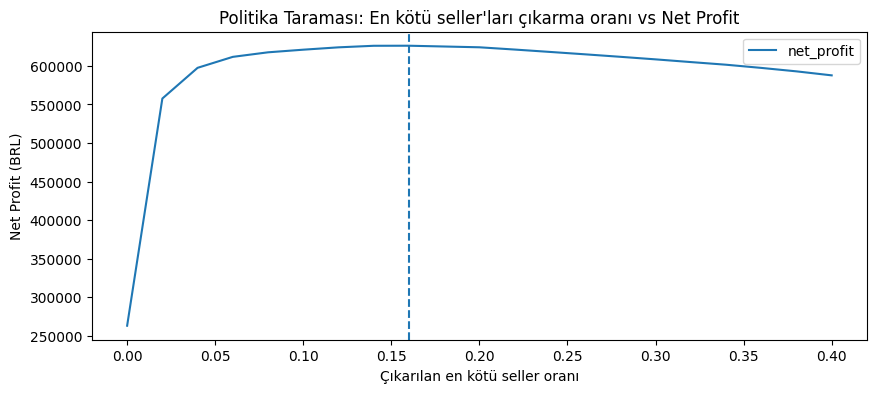

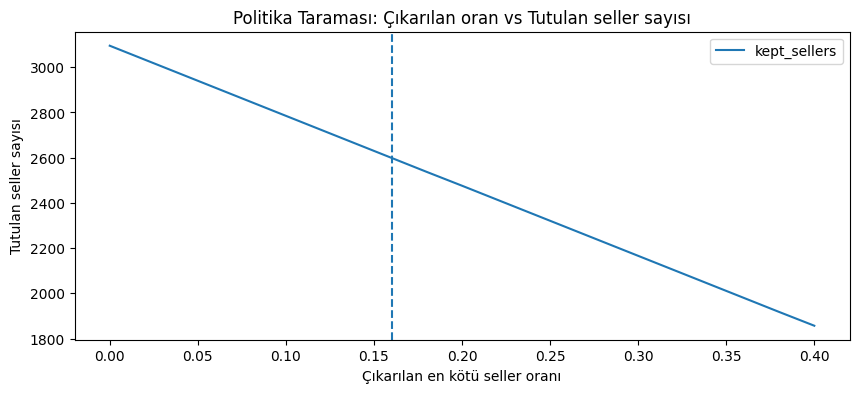

En iyi remove_worst_pct: 0.16
Tutulan seller: 2599
Net profit: 626151.51
Revenue: 2363311.45
Review cost: 818701.67
IT cost: 918458.27


In [23]:
# 1) Net profit vs remove %
ax = res.plot(x="remove_worst_pct", y="net_profit", figsize=(10, 4))
ax.set_title("Politika Taraması: En kötü seller'ları çıkarma oranı vs Net Profit")
ax.set_xlabel("Çıkarılan en kötü seller oranı")
ax.set_ylabel("Net Profit (BRL)")
plt.axvline(res.loc[best_idx, "remove_worst_pct"], linestyle="--")
plt.show()

# 2) Kaç seller kalıyor?
ax2 = res.plot(x="remove_worst_pct", y="kept_sellers", figsize=(10, 4))
ax2.set_title("Politika Taraması: Çıkarılan oran vs Tutulan seller sayısı")
ax2.set_xlabel("Çıkarılan en kötü seller oranı")
ax2.set_ylabel("Tutulan seller sayısı")
plt.axvline(res.loc[best_idx, "remove_worst_pct"], linestyle="--")
plt.show()

print("En iyi remove_worst_pct:", res.loc[best_idx, "remove_worst_pct"])
print("Tutulan seller:", int(res.loc[best_idx, "kept_sellers"]))
print("Net profit:", round(float(res.loc[best_idx, "net_profit"]), 2))
print("Revenue:", round(float(res.loc[best_idx, "total_revenue"]), 2))
print("Review cost:", round(float(res.loc[best_idx, "review_cost"]), 2))
print("IT cost:", round(float(res.loc[best_idx, "it_cost"]), 2))

## CEO Özeti (Karar Notu)

**Amaç:** Olist kârını artırmak için “en kötü performanslı seller’ları platformdan çıkarma” politikasının etkisini simüle ettik.

### Ne yaptık?
- Seller bazında **revenues**, **review_costs** ve **IT_costs** (ölçek ekonomili) üzerinden **net profit** hesapladık.
- “En kötü seller” tanımını, **seller-level profits** (revenues − cost_of_reviews) üzerinden sıralama yaklaşımıyla ele aldık.
- 0%–40% aralığında farklı “çıkarma oranlarını” tarayıp net kârın maksimum olduğu noktayı aradık.

### Sonuç (karar cümlesi)
- Net kâr, belirli bir eşiğe kadar kötü seller’lar çıkarıldığında artıyor; **çok agresif çıkarma** ise gelir kaybı nedeniyle net kârı düşürüyor.
- Bu nedenle önerimiz: **en kötü seller’ların belirli bir yüzdesini (grafikte net kârı maksimize eden oran) kademeli olarak elemek** ve kararı düzenli aralıklarla yeniden kalibre etmek.

### Neden mantıklı?
- Kötü seller’lar **reputation/review maliyetini** büyütüyor ve dolaylı olarak müşteri deneyimini bozuyor.
- IT cost ölçek ekonomisine sahip olsa da, sabit + ölçek maliyeti nedeniyle “her seller’ı tutmak” her zaman optimum değil.
- Optimum nokta, “gelir kaybı” ile “maliyet düşüşü” arasındaki denge.

### Riskler / Dikkat
- “En kötü seller” ölçümü dönemsel dalgalanabilir. Bu yüzden:
  - **balayı (honeymoon)** döneminden sonra değerlendirme,
  - ve/veya **üst üste kötü aylar** gibi kurallarla desteklemek gerekir.
- Bu analiz, veri ve varsayımlara bağlı “what-if” simülasyonudur; canlı ortamda A/B veya kademeli rollout önerilir.